# Imports

In [1]:
import pickle
import os
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib
import torch
import torch_geometric

# print versions
print("torch version: ", torch.__version__)
print("torch geometric version: ", torch_geometric.__version__)
print("torch cuda version: ", torch.version.cuda)
print("torch cuda available: ", torch.cuda.is_available())
# print("torch cuda device count: ", torch.cuda.device_count())
# print("torch cuda current device name: ", torch.cuda.get_device_name(torch.cuda.current_device()))

# print versions
print(f"Pandas version: {pd.__version__}")
print(f"Numpy version: {np.__version__}")
print(f"Matplotlib version: {matplotlib.__version__}")
print(f"NetworkX version: {nx.__version__}")

# set pandas display options to show all columns and rows without truncation
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)
print("\nRemoved truncation of columns")


torch version:  2.6.0+cpu
torch geometric version:  2.6.1
torch cuda version:  None
torch cuda available:  False
Pandas version: 2.2.3
Numpy version: 2.2.4
Matplotlib version: 3.10.1
NetworkX version: 3.4.2

Removed truncation of columns


# Load data

## Load networkx graph

In [2]:
# load the networkx graph
def load_graph(graph_path):
    with open(graph_path, 'rb') as f:
        graph = pickle.load(f)
    return graph

CURR_DIR_PATH = os.getcwd()
PICKLE_GRAPH_FILE_NAME = f"{CURR_DIR_PATH}\\pickle\\max_20000_nodes_graph.gpickle"
PICKLE_GRAPH_FILE_NAME = os.path.abspath(PICKLE_GRAPH_FILE_NAME)

print(f"Loading graph from {PICKLE_GRAPH_FILE_NAME}...")
ntx_graph = load_graph(PICKLE_GRAPH_FILE_NAME)
print(f"Graph loaded. Number of nodes: {ntx_graph.number_of_nodes()}, number of edges: {ntx_graph.number_of_edges()}")


Loading graph from d:\Repos\ut-health-final-proj\pickle\max_20000_nodes_graph.gpickle...
Graph loaded. Number of nodes: 17654, number of edges: 172728


In [3]:
# count nodes of type patient, diagnosis and procedure
def count_node_types(graph):
    node_types = {}
    for node in graph.nodes():
        node_type = graph.nodes[node]['type']
        if node_type not in node_types:
            node_types[node_type] = 0
        node_types[node_type] += 1
    return node_types

node_types = count_node_types(ntx_graph)
print(f"Node counts: {node_types}")

# count edges named had_procedure, has_diagnosis
def count_edge_types(graph):
    edge_types = {}
    for u, v, key in graph.edges(keys=True):
        edge_type = graph.edges[u, v, key]['relation']
        if edge_type not in edge_types:
            edge_types[edge_type] = 0
        edge_types[edge_type] += 1
    return edge_types

edge_types = count_edge_types(ntx_graph)
print(f"Edge counts: {edge_types}")

Node counts: {'patient': 11630, 'diagnosis': 4680, 'procedure': 1344}
Edge counts: {'has_diagnosis': 123987, 'has_procedure': 48741}


## Load patient node similarity dataframe

In [4]:
# load the patient similarity dataframe
def load_patient_similarity_df(df_path):
    with open(df_path, 'rb') as f:
        df = pickle.load(f)
    return df

CURR_DIR_PATH = os.getcwd()
PATIENT_SIMILARITY_DF_FILE_NAME = f"{CURR_DIR_PATH}\\pickle\\max_20000_nodes_similarity.gpickle"
PATIENT_SIMILARITY_DF_FILE_NAME = os.path.abspath(PATIENT_SIMILARITY_DF_FILE_NAME)

print(f"Loading patient similarity dataframe from {PATIENT_SIMILARITY_DF_FILE_NAME}...")
patient_similarity_df = load_patient_similarity_df(PATIENT_SIMILARITY_DF_FILE_NAME)
print(f"Patient similarity dataframe loaded. Number of rows: {patient_similarity_df.shape[0]}")

Loading patient similarity dataframe from d:\Repos\ut-health-final-proj\pickle\max_20000_nodes_similarity.gpickle...
Patient similarity dataframe loaded. Number of rows: 1288402


In [5]:
patient_similarity_df.head(5)

,patient1,patient2,patient1_id,patient2_id,jaccard_similarity,same_gender,same_age_bucket,is_similar
423,patient-4074,patient-10139,4074,10139,0.304348,False,False,True
9670,patient-4074,patient-26572,4074,26572,0.300000,True,True,True
16410,patient-90889,patient-84020,90889,84020,0.344828,True,False,True
17072,patient-90889,patient-67648,90889,67648,0.400000,False,False,True
19221,patient-90889,patient-6138,90889,6138,0.333333,True,False,True


In [6]:
# rename column patient1 to source and patient2 to target
patient_similarity_df.rename(columns={'patient1': 'source_node', 'patient2': 'target_node'}, inplace=True)
patient_similarity_df.head(5)

,source_node,target_node,patient1_id,patient2_id,jaccard_similarity,same_gender,same_age_bucket,is_similar
423,patient-4074,patient-10139,4074,10139,0.304348,False,False,True
9670,patient-4074,patient-26572,4074,26572,0.300000,True,True,True
16410,patient-90889,patient-84020,90889,84020,0.344828,True,False,True
17072,patient-90889,patient-67648,90889,67648,0.400000,False,False,True
19221,patient-90889,patient-6138,90889,6138,0.333333,True,False,True


# Create R-GCN and train the model

### DEBUG

In [7]:
# # Get node types
# node_types = {node_type: [] for node_type in ['patient', 'diagnosis', 'procedure']}
# print(f"node_types: {node_types}")

    
# # Create mappings from original node IDs to new indices for each node type
# node_mappings = {node_type: {} for node_type in node_types}

# print(f"node_mappings: {node_mappings}")
# i=0
# for node, attr in ntx_graph.nodes(data=True):
#     node_type = attr['type']
#     if i ==0:
#         print(f"node: {node}")
#         print(f"attr: {attr}")
#         print(f"node_type: {node_type}")

#     if node not in node_mappings[node_type]:
#         node_mappings[node_type][node] = len(node_mappings[node_type])

#         i+=1
#         print(f"node_mappings[{node_type}][{node}]: {node_mappings[node_type][node]}")
#         print(f"node_mappings[node_type][node]: {node_mappings[node_type][node]}")

#     if i==3:
#         break

# PROMPT:
# Create a relational graph neural network for contrastive learning. The objective is to predict patient similarity. 
# The data is in the networkx graph named ntx_graph. It contains 3 types of nodes: patients, diagnosis and procedure.
# It has edges with the relation of has_diagnosis and had_procedure. 
# The dataframe patient_similarity_df contains patient similarity score in the column "jaccard_similarity". It has source node in column source_node and target node in column target_node. The similar rows have the column is_similar=True and dissimilar rows have is_similar=False.
# Create a relational graph neural network that uses the training data derived from ntx_graph and validation data derived from patient_similarity_df.
# Train and validate the model and print the loss in every iteration.

# Neural Network

Converting NetworkX graph to HeteroData...
type data: <class 'torch_geometric.data.hetero_data.HeteroData'>, type node_mappings: <class 'dict'>
data: HeteroData(
  patient={ x=[11630, 11630] },
  diagnosis={ x=[4680, 4680] },
  procedure={ x=[1344, 1344] },
  (patient, has_diagnosis, diagnosis)={ edge_index=[2, 123987] },
  (patient, has_procedure, procedure)={ edge_index=[2, 48741] }
)
data keys: ['edge_index', 'x']
data['patient'].x: torch.Size([11630, 11630])
data['diagnosis'].x: torch.Size([4680, 4680])
data['procedure'].x: torch.Size([1344, 1344])
data['patient', 'has_diagnosis', 'diagnosis'].edge_index: torch.Size([2, 123987])
data['patient', 'has_procedure', 'procedure'].edge_index: torch.Size([2, 48741])
Processing similarity data...
Created 50000 training pairs from 50000 samples.
Using device: cpu
Training model...
Epoch: 010, Loss: 0.4348
Epoch: 020, Loss: 0.0437
Epoch: 030, Loss: 0.0260
Epoch: 040, Loss: 0.0210
Epoch: 050, Loss: 0.0187
Epoch: 060, Loss: 0.0171
Epoch: 070, L

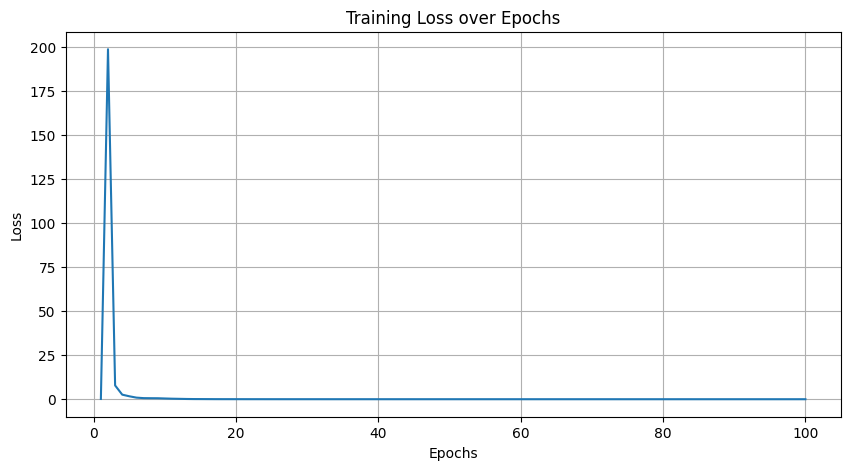

Training finished.


In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric.transforms as T
import torch_geometric
from torch_geometric.data import HeteroData
from torch_geometric.nn import GraphConv

# Convert NetworkX graph to PyTorch Geometric HeteroData
def convert_to_hetero_data(nx_graph):
    """
    Convert a NetworkX graph to PyTorch Geometric HeteroData format.
    The function assumes the graph has node attributes 'type' and edge attributes 'relation'.

    returns:
        data: HeteroData object containing the graph data.
            data = HeteroData(
                patient={ x=[11630, 11630] },
                diagnosis={ x=[4680, 4680] },
                procedure={ x=[1344, 1344] },
                (patient, has_diagnosis, diagnosis)={ edge_index=[2, 123987] },
                (patient, has_procedure, procedure)={ edge_index=[2, 48741] }
                )
        node_mappings: Dictionary mapping original node IDs to new indices for each node type.
        The keys are node types and the values are dictionaries mapping original node IDs to new indices.
            node_mappings[patient][patient-4074]: 0
            node_mappings[patient][patient-90889]: 1
            node_mappings[patient][patient-72753]: 2
            etc.
            node_mappings[diagnosis][diagnosis-1234]: 0
            node_mappings[diagnosis][diagnosis-5678]: 1
            etc.
            node_mappings[procedure][procedure-1234]: 0
            node_mappings[procedure][procedure-5678]: 1
            node_mappings[procedure][procedure-91011]: 2
            etc.
    """
    data = HeteroData()
    
    # Define node types
    node_types_list = ['patient', 'diagnosis', 'procedure']
    
    # Create mappings from original node IDs to new indices for each node type
    # node_mappings: {'patient': {}, 'diagnosis': {}, 'procedure': {}}
    node_mappings = {node_type: {} for node_type in node_types_list}

    # Populate node mappings
    for node, attr in nx_graph.nodes(data=True):

        # get type of node from attribute
        # e.g., attr: {'gender': 'M', 'age_bucket': 80, 'hadm_id': 137421, 'type': 'patient'}
        node_type = attr['type']

        # if type is patient, diagnosis or procedure, add to node_mappings
        # e.g., node_type: patient
        if node_type in node_mappings:

            # if specific patient, diagnosis or procedure node is not in the mapping, add it and assign a new index
            # e.g., node: patient-4074
            if node not in node_mappings[node_type]:

                # Assign a new index to the node in the mapping
                # e.g., node_mappings[patient][patient-4074] = 0
                node_mappings[node_type][node] = len(node_mappings[node_type])
    
    # Add node features (using one-hot encoding)
    for node_type, mapping in node_mappings.items():
        num_nodes = len(mapping)

        # create matrix of size (num_nodes, num_nodes) with 1s on the diagonal and 0s elsewhere
        # e.g., data['patient'].x = torch.eye(num_nodes)
        if num_nodes > 0:
            data[node_type].x = torch.eye(num_nodes)
        else:
            # Handle case where a node type might have 0 nodes
            data[node_type].x = torch.empty((0, 0), dtype=torch.float)

    # Define edge types based on relations found in the graph
    edge_types_relations = {
        'has_diagnosis': ('patient', 'has_diagnosis', 'diagnosis'),
        'has_procedure': ('patient', 'has_procedure', 'procedure')
    }

    # Initialize edge index storage
    for src_type, rel, dst_type in edge_types_relations.values():

        # Initialize edge_index for each relation
        # e.g., data['patient', 'has_diagnosis', 'diagnosis'].edge_index = torch.empty((2, 0), dtype=torch.long)
        # row 0: source node indices (e.g. from patient)
        # row 1: destination node indices (e.g. to diagnosis)
         data[src_type, rel, dst_type].edge_index = torch.empty((2, 0), dtype=torch.long)

    # Add edges
    edge_indices_dict = {rel: [[], []] for rel in edge_types_relations.keys()}

    for u, v, key, attr in nx_graph.edges(keys=True, data=True):
        relation = attr.get('relation')
        if relation in edge_types_relations:
            src_type, _, dst_type = edge_types_relations[relation]
            
            # Determine the correct source and destination based on node types
            u_type = nx_graph.nodes[u]['type']
            v_type = nx_graph.nodes[v]['type']

            # Map original node IDs to new indices
            if u_type == src_type and v_type == dst_type:
                if u in node_mappings[src_type] and v in node_mappings[dst_type]:
                    src_idx = node_mappings[src_type][u]
                    dst_idx = node_mappings[dst_type][v]
                    edge_indices_dict[relation][0].append(src_idx)
                    edge_indices_dict[relation][1].append(dst_idx)
            elif u_type == dst_type and v_type == src_type: # Handle potential reverse direction in source data
                 if v in node_mappings[src_type] and u in node_mappings[dst_type]:
                    src_idx = node_mappings[src_type][v]
                    dst_idx = node_mappings[dst_type][u]
                    edge_indices_dict[relation][0].append(src_idx)
                    edge_indices_dict[relation][1].append(dst_idx)


    # Assign edge indices to the HeteroData object
    for relation, (src_type, rel_key, dst_type) in edge_types_relations.items():
        # Convert edge indices to tensor
        indices = torch.tensor(edge_indices_dict[relation], dtype=torch.long)

        # Ensure edge_index is shape (2, num_edges) even if empty
        data[src_type, rel_key, dst_type].edge_index = indices.view(2, -1)

    return data, node_mappings

# Create RGCN model for contrastive learning
class RGCN(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels, metadata):
        """
        Initialize the RGCN model.
        Args:
            hidden_channels (int): Number of hidden channels for the graph convolution layers.
            out_channels (int): Number of output channels for the projection head.
            metadata (tuple): Metadata containing node types and edge types.
                              metadata[0] is a list of node types
                              metadata[1] is a list of edge types.
        """
        super().__init__()
        
        # Dynamically create convolutions based on metadata
        # Two dicts hold graph convolution layers for each edge type present in the graph
        conv_dict1 = {}
        conv_dict2 = {}

        # Iterate over edge types to create two convolution layers for each edge type
        # metadata[1] is a list of tuples of the form ('src_node_type', 'relation', 'dst_node_type')        
        for edge_type in metadata[1]:

            # Use -1 for input channels to infer automatically
            conv_dict1[edge_type] = GraphConv(-1, hidden_channels)
            conv_dict2[edge_type] = GraphConv(hidden_channels, hidden_channels)

        # HeteroConv allows for different convolution types for different edge types
        # dictionaries of edge convolution layers are used to create hetero convolution layers
        # aggr=sum specifies that messages from different edge types arriving at the same node should be summed up
        self.conv1 = torch_geometric.nn.HeteroConv(conv_dict1, aggr='sum')
        self.conv2 = torch_geometric.nn.HeteroConv(conv_dict2, aggr='sum')

        # Projection head specifically for processing patient nodes and output embeddings for contrastive learning
        # The projection head is a simple feedforward network with two linear layers and ReLU activation
        # The input size to the linear layer depends on the output of conv2 for 'patient' nodes
        self.patient_proj = nn.Sequential(
            nn.Linear(hidden_channels, hidden_channels), # Adjust input size if needed
            nn.ReLU(),
            nn.Linear(hidden_channels, out_channels)
        )
        
    def forward(self, x_dict, edge_index_dict):
        """
        Forward pass through the model.
        Args:
            x_dict (dict): Dictionary of node features for each node type.
            edge_index_dict (dict): Dictionary of edge indices for each edge type.
        Returns:
            torch.Tensor: Projected patient embeddings.
        """

        # First layer
        x_dict = self.conv1(x_dict, edge_index_dict)
        x_dict = {key: F.relu(x) for key, x in x_dict.items()}
        
        # Second layer
        x_dict = self.conv2(x_dict, edge_index_dict)

        # No ReLU after the second layer before projection
        
        # Project patient embeddings for contrastive learning
        # Check if 'patient' key exists before projecting
        if 'patient' in x_dict:
            patient_emb = self.patient_proj(x_dict['patient'])
            return patient_emb
        else:
            # Handle cases where 'patient' embeddings might not be produced (e.g., graph structure)
            return None # Or raise an error, or return an empty tensor

# Create a contrastive loss function
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=0.5):
        """
        Initialize the Contrastive Loss function.
        Args:
            margin (float): Margin is the radius of the circle in which the positive pairs are located.
        """
        super(ContrastiveLoss, self).__init__()
        self.margin = margin
        
    def forward(self, embeddings, pairs, labels):
        """
        Forward pass for the contrastive loss.
        Args:
            embeddings (torch.Tensor): Node embeddings from the model.
            pairs (torch.Tensor): Pairs of node indices for which to compute the loss.
            labels (torch.Tensor): Labels indicating whether pairs are similar (0) or dissimilar (1).

        """
        # Ensure pairs and labels are on the same device as embeddings
        pairs = pairs.to(embeddings.device)
        labels = labels.to(embeddings.device)

        # Extract embeddings for pairs
        # Ensure indices in pairs are within the bounds of embeddings (prevents out of bound errors)
        valid_indices_mask = (pairs[:, 0] < embeddings.size(0)) & (pairs[:, 1] < embeddings.size(0))

        # only keep valid pairs and labels
        # valid_pairs: pairs where both indices are within bounds
        valid_pairs = pairs[valid_indices_mask]
        valid_labels = labels[valid_indices_mask]

        if valid_pairs.size(0) == 0:
            return torch.tensor(0.0, device=embeddings.device, requires_grad=True) # Return zero loss if no valid pairs

        embeddings1 = embeddings[valid_pairs[:, 0]]
        embeddings2 = embeddings[valid_pairs[:, 1]]
        
        # Calculate Euclidean distance
        distances = F.pairwise_distance(embeddings1, embeddings2)
        
        # Calculate loss based on labels (0 for similar, 1 for dissimilar)
        # Loss for similar pairs (label=0): distance^2
        # Loss for dissimilar pairs (label=1): max(0, margin - distance)^2
        loss_similar = (1 - valid_labels) * torch.pow(distances, 2)
        loss_dissimilar = valid_labels * torch.pow(torch.clamp(self.margin - distances, min=0.0), 2)
        
        loss = loss_similar + loss_dissimilar
        return loss.mean()

# Process NetworkX graph
print("Converting NetworkX graph to HeteroData...")
data, node_mappings = convert_to_hetero_data(ntx_graph)

print(f"type data: {type(data)}, type node_mappings: {type(node_mappings)}")

# Create a training-validation split by masking nodes rather than slicing the data
# We'll use a random subset of patient nodes for inference
# import random

# # Get list of patient indices
# patient_indices = list(range(data['patient'].x.shape[0]))

# # Shuffle the indices for randomness
# random.shuffle(patient_indices)

# # Split into training (99%) and inference (1%)
# split_idx = int(0.99 * len(patient_indices))
# train_indices = patient_indices[:split_idx]
# test_indices = patient_indices[split_idx:]

# print(f"Using {len(train_indices)} patients for training and {len(test_indices)} patients for testing")

# # Create a mask for training and testing
# train_mask = torch.zeros(data['patient'].x.shape[0], dtype=torch.bool)
# train_mask[train_indices] = True

# # We'll keep the original data object intact, and use masks during training/testing
# data.train_mask = train_mask

# data.test_mask = torch.zeros(data['patient'].x.shape[0], dtype=torch.bool)
# data.test_mask[test_indices] = True


# print first 5 elements of data
print(f"data: {data}")
print(f"data keys: {data.keys()}")
print(f"data['patient'].x: {data['patient'].x.shape}")
print(f"data['diagnosis'].x: {data['diagnosis'].x.shape}")
print(f"data['procedure'].x: {data['procedure'].x.shape}")
print(f"data['patient', 'has_diagnosis', 'diagnosis'].edge_index: {data['patient', 'has_diagnosis', 'diagnosis'].edge_index.shape}")
print(f"data['patient', 'has_procedure', 'procedure'].edge_index: {data['patient', 'has_procedure', 'procedure'].edge_index.shape}")


# Add reverse edges to make the graph effectively undirected for message passing
transform = T.ToUndirected()
data = transform(data)

# Create a lookup from original patient node ID to new sequential index
patient_node_lookup = {node: idx for node, idx in node_mappings.get('patient', {}).items()}

# Process similarity data for training
print("Processing similarity data...")
sim_pairs_list = []
sim_labels_list = []

# Consider using a subset for faster training/debugging if the dataset is large
# Determine sample size (e.g., 50k or full dataset)
sample_size = min(50000, len(patient_similarity_df))

# Use random sampling if taking a subset
subset_df = patient_similarity_df.sample(n=sample_size, random_state=42) if sample_size < len(patient_similarity_df) else patient_similarity_df


for _, row in subset_df.iterrows():
    source = row['source_node']
    target = row['target_node']
    # Check if both source and target patients are in our mapping
    if source in patient_node_lookup and target in patient_node_lookup:
        source_idx = patient_node_lookup[source]
        target_idx = patient_node_lookup[target]
        sim_pairs_list.append([source_idx, target_idx])
        # Use 0 for similar, 1 for dissimilar for the contrastive loss formula used
        sim_labels_list.append(0.0 if row['is_similar'] else 1.0)

if not sim_pairs_list:
     raise ValueError("No valid training pairs found. Check patient IDs in similarity data and graph.")

sim_pairs = torch.tensor(sim_pairs_list, dtype=torch.long)
sim_labels = torch.tensor(sim_labels_list, dtype=torch.float)

print(f"Created {len(sim_pairs)} training pairs from {sample_size} samples.")

# --- Model, Optimizer, and Training Setup ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Ensure data is on the correct device
data = data.to(device)
sim_pairs = sim_pairs.to(device)
sim_labels = sim_labels.to(device)


# Create the model
hidden_channels = 64
out_channels = 32
model = RGCN(hidden_channels, out_channels, data.metadata()).to(device)

# Set up optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4) # Added weight decay
criterion = ContrastiveLoss(margin=1.0) # Adjusted margin

# Training loop
def train():
    model.train()
    optimizer.zero_grad()
    
    # Get patient embeddings
    patient_embeddings = model(data.x_dict, data.edge_index_dict)
    
    if patient_embeddings is None or patient_embeddings.size(0) == 0:
         print("Warning: No patient embeddings generated.")
         return 0.0 # Or handle appropriately

    # Compute loss using only the patient embeddings
    loss = criterion(patient_embeddings, sim_pairs, sim_labels)
    
    if loss.requires_grad:
        # Backpropagation
        loss.backward()
        optimizer.step()
        return loss.item()
    else:
        # Handle cases where loss does not require gradients (e.g., no valid pairs)
        print("Warning: Loss does not require gradients.")
        return loss.item() # Return the scalar value

# Train the model
print("Training model...")
num_epochs = 100 # Increased epochs
losses = [] # Track losses for visualization

for epoch in range(num_epochs):
    loss = train()
    losses.append(loss)
    if (epoch + 1) % 10 == 0: # Print loss every 10 epochs
        print(f'Epoch: {epoch+1:03d}, Loss: {loss:.4f}')

# Plot training loss
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.grid(True)
plt.show()

print("Training finished.")

# Save and Load Model

## Save model

In [9]:
# save the model to a file
MODEL_FILE_NAME = f"{CURR_DIR_PATH}\\models\\rgcn_model.pth"
torch.save(model.state_dict(), MODEL_FILE_NAME)
print(f"Model saved to {MODEL_FILE_NAME}")

Model saved to d:\Repos\ut-health-final-proj\models\rgcn_model.pth


## Load model

In [10]:

# load the model from a file
def load_model(model, file_path):
    model.load_state_dict(torch.load(file_path))
    model.eval()
    return model

# load the model from a file
model = RGCN(hidden_channels, out_channels, data.metadata()).to(device)
model = load_model(model, MODEL_FILE_NAME)
print(f"Model loaded from {MODEL_FILE_NAME}")


# print model summary
def print_model_summary(model):
    print("Model Summary:")
    print(model)
    # print("\nModel Parameters:")
    # for name, param in model.named_parameters():
    #     if param.requires_grad:
    #         print(f"{name}: {param.data.size()}")
    # print("\nModel Forward Pass:")
    # for name, param in model.named_parameters():
    #     if param.requires_grad:
    #         print(f"{name}: {param.data.size()}")
    # print("\nModel Forward Pass:")
    # print("Input Data:")
    # print(f"data.x_dict: {data.x_dict}")
    # print(f"data.edge_index_dict: {data.edge_index_dict}")
    print("Output Data:")
    print(f"patient_embeddings: {model(data.x_dict, data.edge_index_dict)}")
    print("\nModel Summary Finished.")

print_model_summary(model)
# print model summary
print("Model summary printed.")

Model loaded from d:\Repos\ut-health-final-proj\models\rgcn_model.pth
Model Summary:
RGCN(
  (conv1): HeteroConv(num_relations=4)
  (conv2): HeteroConv(num_relations=4)
  (patient_proj): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
  )
)
Output Data:
patient_embeddings: tensor([[-1.6555,  0.7610, -1.9138,  ..., -0.7236,  1.5546,  1.2871],
        [-0.1533,  0.1973, -0.3736,  ...,  0.0697,  0.1643, -0.1748],
        [-0.1990, -0.0585, -0.3403,  ...,  0.0047,  0.1228, -0.0633],
        ...,
        [-1.7869,  1.0348, -2.2387,  ..., -1.2029,  1.9448,  1.8176],
        [-0.8975,  0.4117, -1.0403,  ..., -0.3545,  0.8090,  0.6734],
        [-0.0948,  0.1398, -0.2501,  ...,  0.0445,  0.1053, -0.1531]],
       grad_fn=<AddmmBackward0>)

Model Summary Finished.
Model summary printed.


# Inference

In [11]:
# Get patient embeddings with the trained model
model.eval()  # Set the model to evaluation mode

with torch.no_grad():

    # Generate patient embeddings
    patient_embeddings = model(data.x_dict, data.edge_index_dict)
    
    # Select a small sample of patient pairs for inference
    num_samples = 100
    sample_indices = np.random.choice(len(sim_pairs), num_samples, replace=False)
    
    sample_pairs = sim_pairs[sample_indices]
    sample_labels = sim_labels[sample_indices]
    
    # Extract embeddings for the sampled pairs
    embeddings1 = patient_embeddings[sample_pairs[:, 0]]
    embeddings2 = patient_embeddings[sample_pairs[:, 1]]
    
    # Calculate Euclidean distances between pairs
    distances = F.pairwise_distance(embeddings1, embeddings2).cpu().numpy()
    
    # Convert to similarity scores (inverse of distance)
    similarities = 1.0 / (1.0 + distances)
    
    # Prepare results in a DataFrame
    result_df = pd.DataFrame({
        'source_idx': sample_pairs[:, 0].cpu().numpy(),
        'target_idx': sample_pairs[:, 1].cpu().numpy(),
        'predicted_similarity': similarities,
        'actual_label': sample_labels.cpu().numpy(),  # 0 for similar, 1 for dissimilar
    })
    
    # Map indices back to original patient IDs
    reverse_lookup = {idx: node_id for node_id, idx in patient_node_lookup.items()}
    result_df['source_node'] = result_df['source_idx'].map(reverse_lookup)
    result_df['target_node'] = result_df['target_idx'].map(reverse_lookup)
    
    # Calculate accuracy based on a threshold
    threshold = 0.5
    result_df['predicted_label'] = (result_df['predicted_similarity'] < threshold).astype(float)
    result_df['is_correct'] = (result_df['predicted_label'] == result_df['actual_label'])
    
    accuracy = result_df['is_correct'].mean() * 100
    
    print(f"Sample inference completed with {accuracy:.2f}% accuracy")
    print(f"Sample size: {num_samples}")
    print(result_df.head(10))

# Store embeddings for all patients
all_patient_embeddings = patient_embeddings.cpu().numpy()
print(f"Saved embeddings for {all_patient_embeddings.shape[0]} patients, each with {all_patient_embeddings.shape[1]} dimensions")

Sample inference completed with 95.00% accuracy
Sample size: 100
   source_idx  target_idx  predicted_similarity  actual_label    source_node  \
0         223         229              0.157102           1.0   patient-4152   
1        2167        9976              0.399010           1.0  patient-25677   
2        2901        4021              0.160845           1.0   patient-5344   
3         253         625              0.999994           0.0  patient-16323   
4        1850        6550              0.500824           1.0  patient-14619   
5        3781        4258              0.999994           0.0  patient-24627   
6          87       10533              0.999994           0.0  patient-26032   
7        5128       10376              0.237967           1.0  patient-13062   
8        2525        8905              0.999994           0.0  patient-30853   
9        4698        5414              0.999994           0.0  patient-26641   

     target_node  predicted_label  is_correct  
0  pat